[FUENTE DE INFORMACION: Estudio de Conjunto de datos desequilibrados para la detección de fraude con tarjeta de crédito- url: (https://www.kaggle.com/datasets/dark06thunder/credit-card-dataset?select=credit_dataset.csv)](https://www.kaggle.com/datasets/dark06thunder/credit-card-dataset?select=credit_dataset.csv)

<a id='Indice'></a>
## Índice
[Inicio ▲](#Indice)
1. [Estudiando el conjunto de Datos](#estudiando-los-datos)
    1. [Graficando las clases](#grafico-clases)
1. [Aplicando SMOTE](#aplicando-smote)
    1. [Evaluando Resultados - multiparametricos](#resultados-smote)

In [1]:
import pandas as pd 
import numpy as np

import smote_variants as sv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


## Preparacion de los datos

In [2]:
df = pd.read_csv('credit_dataset.csv')

In [13]:
fraudes_detectados = df[df['TARGET'] == 1]
fraudes_detectados

,Unnamed: 0,ID,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
508,508,5009628,F,N,N,0,238500.0,Working,Secondary / secondary special,Married,House / apartment,1,1,0,0,2.0,59,53,9,1
664,664,5009938,F,N,Y,2,157500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,4.0,39,29,6,1
956,956,5010535,F,Y,N,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,4.0,52,38,8,1
960,960,5010541,F,Y,N,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,4.0,52,38,8,1
1177,1177,5010864,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,1,3.0,51,50,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25129,25129,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,11,48,7,1
25130,25130,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,2.0,23,34,4,1
25131,25131,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,2.0,32,34,4,1
25132,25132,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,9,49,2,1


In [4]:
fraudes_detectados.describe()

,Unnamed: 0,ID,NO_OF_CHILD,INCOME,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
count,422.000000,4.220000e+02,422.000000,422.000000,422.0,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.0
mean,20567.625592,5.085477e+06,0.507109,200056.148104,1.0,0.293839,0.303318,0.101896,2.253555,33.758294,39.959716,5.566351,1.0
std,6990.117451,4.204221e+04,0.791101,102783.038134,0.0,0.456060,0.460237,0.302870,0.972141,15.607823,9.547023,5.196756,0.0
min,508.000000,5.009524e+06,0.000000,36000.000000,1.0,0.000000,0.000000,0.000000,1.000000,2.000000,22.000000,0.000000,1.0
25%,17653.250000,5.051086e+06,0.000000,135000.000000,1.0,0.000000,0.000000,0.000000,2.000000,21.000000,31.000000,2.000000,1.0
50%,24922.500000,5.092006e+06,0.000000,180000.000000,1.0,0.000000,0.000000,0.000000,2.000000,35.000000,40.000000,4.000000,1.0
75%,25027.750000,5.118357e+06,1.000000,247500.000000,1.0,1.000000,1.000000,0.000000,3.000000,47.000000,48.000000,8.000000,1.0
max,25133.000000,5.150337e+06,4.000000,900000.000000,1.0,1.000000,1.000000,1.000000,6.000000,60.000000,62.000000,29.000000,1.0


In [10]:
import numpy as np
import matplotlib.pyplot as plt

index = np.arange(start=0, stop=fraudes_detectados['INCOME'].count()+1)
# print(index)
unicos = fraudes_detectados['INCOME'].rank()
type(unicos)

# ts = pd.Series(fraudes_detectados['INCOME'],index=index)
# ts.plot()
# plt.show()

pandas.core.series.Series

ejemplo de fraude:
- mujer (F)
- sin auto (N)
- sin hijos (0)
- ingreso 238500
- tipo de ingreso: trabajo 
- tipo de educacion: secundario/ secundario especial
- tipo de familia: casada 
- tipo de casa: casa/ apartamento 
- auto: si (1)
- telefono laboral
- tiene email
- tamaño familia: 2
- mes de inicio: 59
- año: 52
- años empleada: 7

In [3]:
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)
to_drop = ['Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Fusionar en un solo Dataframe
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
from sklearn.preprocessing import MinMaxScaler

# Escalar solo columnas que tengan valores mayores que 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Reemplazar las columnas originales con escalas
for col in scaled:
    merged[col] = scaled[col]
    
merged.head()
data = merged

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   GENDER                                  25134 non-null  int64  
 1   CAR                                     25134 non-null  int64  
 2   REALITY                                 25134 non-null  int64  
 3   NO_OF_CHILD                             25134 non-null  float64
 4   INCOME                                  25134 non-null  float64
 5   WORK_PHONE                              25134 non-null  int64  
 6   PHONE                                   25134 non-null  int64  
 7   E_MAIL                                  25134 non-null  int64  
 8   FAMILY SIZE                             25134 non-null  float64
 9   BEGIN_MONTH                             25134 non-null  float64
 10  AGE                                     25134 non-null  fl

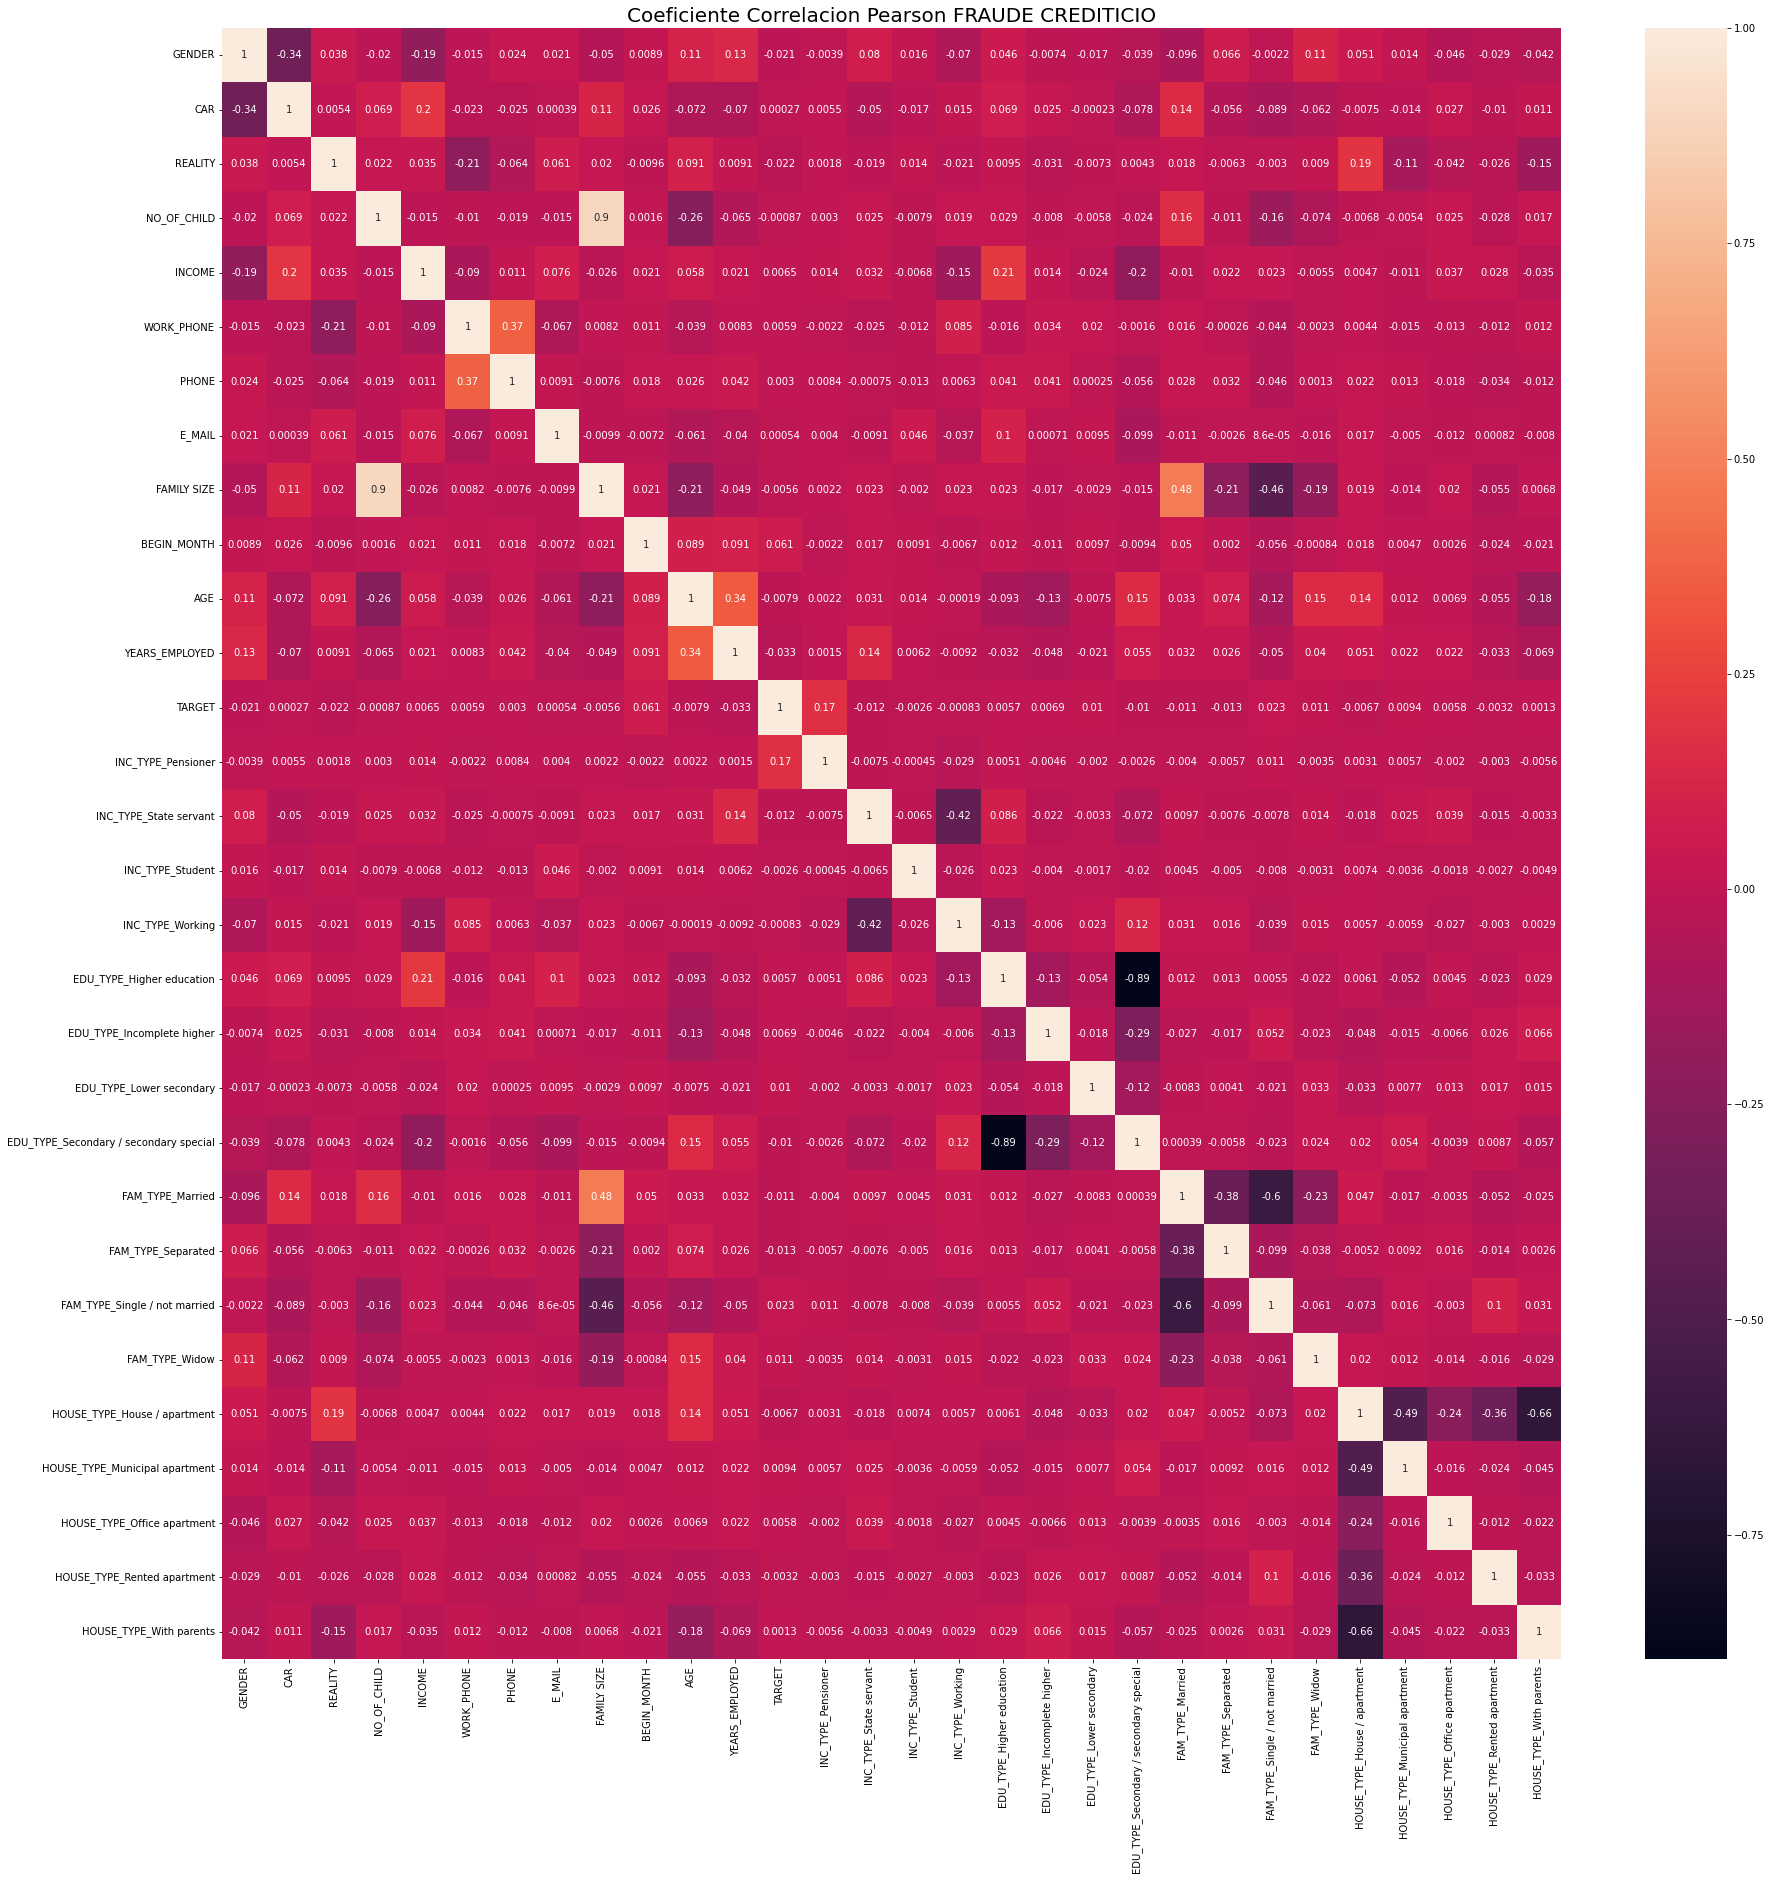

In [17]:
import seaborn as sns

# corr_df = data.corr()
corr_df = data.corr(method='pearson')

plt.figure(figsize=(30, 30))
sns.heatmap(corr_df, annot=True)
plt.title('Coeficiente Correlacion Pearson FRAUDE CREDITICIO', fontsize=20)
plt.show()

In [18]:
data.shape

(25134, 30)

In [19]:
X, y = data.drop(['TARGET'], axis=1), data['TARGET']

In [32]:
X.T

,0,1,2,3,4,5,6,7,8,9,...,25124,25125,25126,25127,25128,25129,25130,25131,25132,25133
GENDER,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
CAR,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
REALITY,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NO_OF_CHILD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
INCOME,0.055233,0.156977,0.156977,0.156977,0.156977,0.156977,0.156977,0.069767,0.069767,0.069767,...,0.098837,0.142442,0.142442,0.273256,0.066860,0.186047,0.084302,0.084302,0.165698,0.055233
WORK_PHONE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PHONE,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
E_MAIL,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
FAMILY SIZE,0.052632,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,0.052632,0.052632,0.052632,...,0.052632,0.052632,0.052632,0.105263,0.052632,0.052632,0.052632,0.052632,0.052632,0.000000
BEGIN_MONTH,0.483333,0.066667,0.433333,0.433333,0.633333,0.083333,0.700000,0.283333,0.266667,0.133333,...,0.416667,0.416667,0.466667,0.183333,0.316667,0.183333,0.383333,0.533333,0.150000,0.216667


In [35]:
from sklearn.decomposition import PCA
PCA = PCA(n_components=2)
components = PCA.fit_transform(X)
PCA.components_

array([[ 4.87466680e-02,  1.00325821e-01,  9.64462359e-03,
         1.95706995e-03,  2.48780897e-02, -1.74843924e-02,
         5.54755672e-02,  6.23473422e-02,  1.87225282e-03,
         6.75687130e-03, -4.28631243e-02, -9.98219497e-03,
         3.22536963e-04,  8.52398880e-02,  7.63044789e-04,
        -2.37072336e-01,  6.57516739e-01,  3.04109352e-02,
         4.32645230e-03, -6.92875926e-01,  6.93087802e-03,
         6.51282377e-04,  8.58631316e-03, -7.13600858e-03,
        -6.56953009e-03, -1.43903131e-02,  1.40241420e-03,
        -3.33485632e-03,  1.81970059e-02],
       [ 5.73129003e-01, -6.20004064e-01,  5.96216538e-02,
        -8.72221285e-03, -1.81530787e-02, -6.57852221e-02,
        -2.38910685e-02,  1.50440454e-02, -2.63806431e-02,
        -1.82425092e-02,  3.19040176e-02,  2.46397678e-02,
         8.23425484e-05,  8.28367591e-02,  6.36351045e-04,
        -1.89818240e-01, -7.89311318e-03, -3.96102105e-03,
        -2.07697140e-03,  1.41897955e-02, -4.20692482e-01,
         7.90

In [36]:
cumVar = pd.DataFrame(np.cumsum(PCA.explained_variance_ratio_)*100, 
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(PCA.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1)\
    .rename(index={0: "PC1", 1: "PC2"})

,VarPerc,cumVarPerc
PC1,15.196855,15.196855
PC2,12.648951,27.845807


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

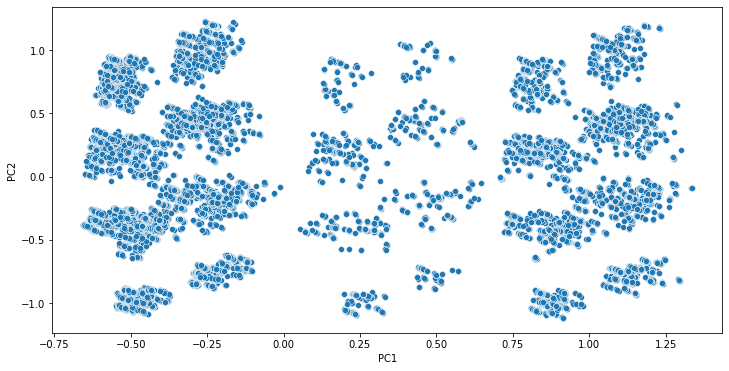

In [38]:
componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
pcaDf = pd.concat([componentsDf, Y], axis=1)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pcaDf, x="PC1", y="PC2")

In [13]:
cov_mat = np.cov(X.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 4.87466657e-02 -5.73129024e-01  6.85961849e-02  3.70228454e-01
   1.01319896e-01 -1.51425971e-01 -6.77606292e-01  9.80818752e-02
   8.70591010e-02 -2.54354603e-02 -1.10396033e-01  6.84492702e-03
   2.31642499e-02  5.69717157e-04  4.07167613e-02 -2.97781230e-02
  -2.19116304e-02  1.13006226e-02 -1.89519795e-02  9.77874256e-03
  -6.79950123e-03  6.98819242e-03  2.61424107e-02 -4.80191095e-03
  -2.77126141e-05 -1.44234008e-04  1.11106496e-04 -5.96516434e-04
   2.19261299e-05]
 [ 1.00325823e-01  6.20004080e-01 -1.49611971e-01 -2.13834495e-01
  -1.09481691e-01  1.91206097e-01 -6.94226267e-01  4.77143021e-02
   4.06331488e-02 -7.34926711e-03 -2.53123947e-02  1.06973064e-02
  -3.72489738e-02  1.35872705e-02 -5.72692447e-03  1.14143509e-02
  -7.24325926e-03  2.29996703e-03  5.09620488e-04 -1.04525643e-04
  -1.56432264e-03 -5.40082760e-03 -1.87478666e-02 -3.24978620e-03
   4.56991675e-04  1.70306317e-04 -6.07368966e-04 -5.18525311e-04
   2.47683403e-05]
 [ 9.64462645e-03 -5.962

In [16]:
#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')

for i in eig_pairs:
    i2 = i[0]

Autovalores en orden descendiente:
0.4205328968230146
0.35002637372100115
0.3077679762080313
0.2643218454997381
0.23992263170210135
0.21370422196777597
0.15401031465815299
0.13217646056212062
0.1188915560197496
0.08879874741208794
0.08390531744243203
0.07488547161541276
0.06626095910321304
0.05763984484235853
0.043723807288349
0.037811960854872755
0.03292270959259919
0.020957726347573938
0.01724393537579888
0.013693853101462037
0.00965950058326427
0.0093409822021687
0.0038631433021757322
0.0029887593757333066
0.001132704574712537
0.0005160215287949246
0.0003957793631037804
0.00013797556103401108
2.8406862886882617e-06


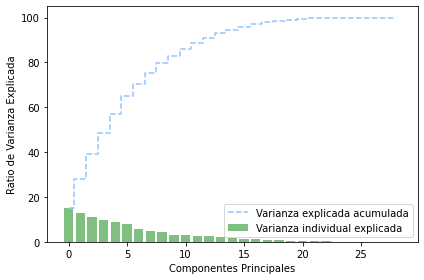

In [29]:
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(29), var_exp, alpha=0.5, align='center',
            label='Varianza individual explicada', color='g')
    plt.step(range(29), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout()

In [28]:
#Generamos la matríz a partir de los pares autovalor-autovector
matrix_w = np.hstack((eig_pairs[0][1].reshape(29,1),
                      eig_pairs[1][1].reshape(29,1)))

print('Matriz W:\n', matrix_w)

Y = X.dot(matrix_w)

Matriz W:
 [[ 4.87466657e-02 -5.73129024e-01]
 [ 1.00325823e-01  6.20004080e-01]
 [ 9.64462645e-03 -5.96216289e-02]
 [ 1.95707022e-03  8.72221371e-03]
 [ 2.48780887e-02  1.81530702e-02]
 [-1.74843950e-02  6.57851977e-02]
 [ 5.54755677e-02  2.38910718e-02]
 [ 6.23473426e-02 -1.50440411e-02]
 [ 1.87225289e-03  2.63806421e-02]
 [ 6.75691019e-03  1.82428617e-02]
 [-4.28631235e-02 -3.19039910e-02]
 [-9.98218293e-03 -2.46396504e-02]
 [ 3.22536719e-04 -8.23447904e-05]
 [ 8.52399846e-02 -8.28358913e-02]
 [ 7.63044611e-04 -6.36352610e-04]
 [-2.37072301e-01  1.89818554e-01]
 [ 6.57516719e-01  7.89291882e-03]
 [ 3.04109696e-02  3.96135583e-03]
 [ 4.32645516e-03  2.07699870e-03]
 [-6.92875943e-01 -1.41899627e-02]
 [ 6.93088106e-03  4.20692508e-01]
 [ 6.51270749e-04 -7.90147796e-02]
 [ 8.58632877e-03 -2.16443428e-01]
 [-7.13600847e-03 -4.16427963e-02]
 [-6.56953009e-03 -1.17272170e-02]
 [-1.43903079e-02 -5.76174057e-03]
 [ 1.40241522e-03  4.80756235e-03]
 [-3.33485585e-03 -4.32755159e-03]
 [ 1.8196

In [30]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('magenta', 'cyan', 'limegreen')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

InvalidIndexError: (0        False
1        False
2        False
3        False
4        False
         ...  
25129    False
25130    False
25131    False
25132    False
25133    False
Name: TARGET, Length: 25134, dtype: bool, 0)

<Figure size 432x288 with 0 Axes>

<a id='grafico-clases'></a>
## Grafico de Clases
[Inicio ▲](#Indice)

Text(0.5, 1.0, 'Distribucion de clases sin aplicar SMOTE')

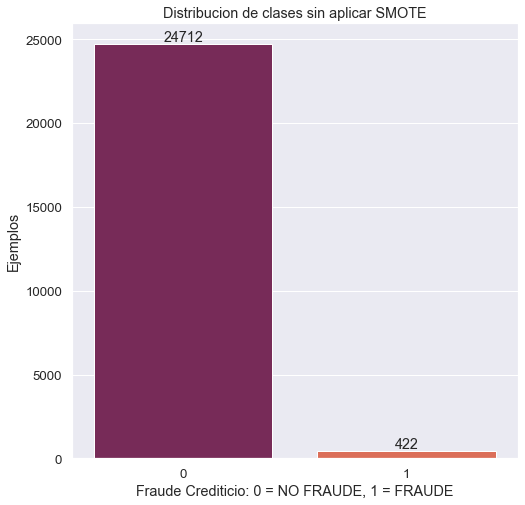

In [8]:
ax =  sns.countplot(x='TARGET', data=data, palette='rocket')

abs_values = data['TARGET'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = NO FRAUDE, 1 = FRAUDE')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Distribucion de clases sin aplicar SMOTE')

[Text(0, 0, '24712'), Text(0, 0, '422')]

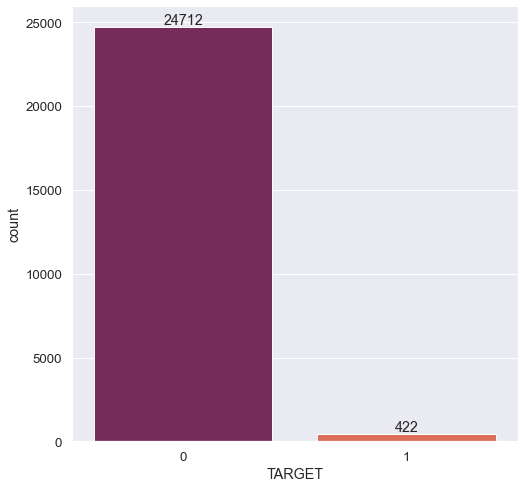

In [5]:
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': [8, 8]}, font_scale=1.2)

ax =  sns.countplot(x='TARGET', data=data, palette='rocket')

abs_values = data['TARGET'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

In [21]:
data.columns.values

array(['GENDER', 'CAR', 'REALITY', 'NO_OF_CHILD', 'INCOME', 'WORK_PHONE',
       'PHONE', 'E_MAIL', 'FAMILY SIZE', 'BEGIN_MONTH', 'AGE',
       'YEARS_EMPLOYED', 'TARGET', 'INC_TYPE_Pensioner',
       'INC_TYPE_State servant', 'INC_TYPE_Student', 'INC_TYPE_Working',
       'EDU_TYPE_Higher education', 'EDU_TYPE_Incomplete higher',
       'EDU_TYPE_Lower secondary',
       'EDU_TYPE_Secondary / secondary special', 'FAM_TYPE_Married',
       'FAM_TYPE_Separated', 'FAM_TYPE_Single / not married',
       'FAM_TYPE_Widow', 'HOUSE_TYPE_House / apartment',
       'HOUSE_TYPE_Municipal apartment', 'HOUSE_TYPE_Office apartment',
       'HOUSE_TYPE_Rented apartment', 'HOUSE_TYPE_With parents'],
      dtype=object)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=42)

In [24]:
dataTrain = pd.DataFrame(X_train, y_train, columns = data.columns.values)
print(dataTrain.shape)
print(dataTrain.columns.values)
No_fraude = dataTrain.query('TARGET == 0')
Fraude = dataTrain.query('TARGET == 1')

print("Datos de Entrenamiento: \n No Fraude", No_fraude.size, "\n Fraude: ", Fraude.size)

(16839, 30)
['GENDER' 'CAR' 'REALITY' 'NO_OF_CHILD' 'INCOME' 'WORK_PHONE' 'PHONE'
 'E_MAIL' 'FAMILY SIZE' 'BEGIN_MONTH' 'AGE' 'YEARS_EMPLOYED' 'TARGET'
 'INC_TYPE_Pensioner' 'INC_TYPE_State servant' 'INC_TYPE_Student'
 'INC_TYPE_Working' 'EDU_TYPE_Higher education'
 'EDU_TYPE_Incomplete higher' 'EDU_TYPE_Lower secondary'
 'EDU_TYPE_Secondary / secondary special' 'FAM_TYPE_Married'
 'FAM_TYPE_Separated' 'FAM_TYPE_Single / not married' 'FAM_TYPE_Widow'
 'HOUSE_TYPE_House / apartment' 'HOUSE_TYPE_Municipal apartment'
 'HOUSE_TYPE_Office apartment' 'HOUSE_TYPE_Rented apartment'
 'HOUSE_TYPE_With parents']
Datos de Entrenamiento: 
 No Fraude 0 
 Fraude:  0


In [25]:
from sklearn.metrics import confusion_matrix


clasifier = RandomForestClassifier(random_state=42, n_estimators=100)
# clasifier= GaussianNB()

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# performance = clasifier.score(X_test, y_test)
print('Confusion matrix\n\n', cm)
# print(classification_report(y_test, y_pred))
# print('performance: ', performance)
# Thus in binary classification, the count of true negatives is
# :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
# :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
def calculoF1_score(cm):
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    return (2*TP)/((2*TP)+FP+FN)

print('Calculo del F1 Score es: ', calculoF1_score(cm))

Confusion matrix

 [[8124   27]
 [ 129   15]]
Calculo del F1 Score es:  0.16129032258064516


<a id='aplicando-smote'></a>
## Aplicando SMOTE
[Inicio ▲](#Indice)

## Montaje de un pipeline

metricas: https://scikit-learn.org/stable/_sources/modules/model_evaluation.rst.txt

In [32]:
# oversampler= sv.SMOTE()
# oversampler= sv.SMOTE_IPF()
# oversampler= sv.SMOTE_ENN()
oversampler= sv.SMOTE_TomekLinks()
# classifier= GaussianNB()
classifier= RandomForestClassifier(random_state=42, n_estimators=500)
model= Pipeline([
                ('scale', StandardScaler()),
                ('clf', sv.OversamplingClassifier(oversampler, classifier))
            ])
# model.fit(X_train, y_train) # el conjunto de entrenamiento es el 67% 
param_grid= {'clf__oversampler':[sv.distance_SMOTE(proportion=0.2),
                                 sv.distance_SMOTE(proportion=0.3),
                                 sv.distance_SMOTE(proportion=0.4),
                                 sv.distance_SMOTE(proportion=0.5),
                                 sv.distance_SMOTE(proportion=0.6),
                                 sv.distance_SMOTE(proportion=0.7),
                                 sv.distance_SMOTE(proportion=0.8),
                                 sv.distance_SMOTE(proportion=0.9),
                                 sv.distance_SMOTE(proportion=1.0)]}

# param_grid['clf__oversampler']
scoring = {"recall": "recall", "precision": "precision", "f1" : "f1"}
grid= GridSearchCV(model, param_grid= param_grid, cv= 3, n_jobs= 1, verbose= 2, scoring= scoring, refit='recall' ) #probar con lista ['f1','recall','precision']
grid.fit(X_train, y_train)

2022-07-12 12:20:55,325:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits


2022-07-12 12:21:00,223:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   4.8s


2022-07-12 12:21:05,071:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   4.7s


2022-07-12 12:21:09,748:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   4.6s


2022-07-12 12:21:14,962:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   5.1s


2022-07-12 12:21:20,161:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   5.1s


2022-07-12 12:21:25,247:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   5.0s


2022-07-12 12:21:31,028:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   5.7s


2022-07-12 12:21:36,784:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   5.7s


2022-07-12 12:21:42,406:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   5.5s


2022-07-12 12:21:48,785:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   6.3s


2022-07-12 12:21:55,238:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   6.3s


2022-07-12 12:22:01,438:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   6.1s


2022-07-12 12:22:08,461:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   6.9s


2022-07-12 12:22:15,363:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   6.8s


2022-07-12 12:22:22,081:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   6.6s


2022-07-12 12:22:29,700:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   7.5s


2022-07-12 12:22:37,131:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   7.3s


2022-07-12 12:22:44,385:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   7.1s


2022-07-12 12:22:52,555:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   8.1s


2022-07-12 12:23:00,721:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   8.1s


2022-07-12 12:23:08,509:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   7.7s


2022-07-12 12:23:17,217:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   8.6s


2022-07-12 12:23:25,992:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   8.7s


2022-07-12 12:23:34,323:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   8.2s


2022-07-12 12:23:43,659:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   9.2s


2022-07-12 12:23:52,952:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   9.2s


2022-07-12 12:24:01,928:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   8.9s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        OversamplingClassifier(classifier=RandomForestClassifier(n_estimators=500,
                                                                                                 random_state=42),
                                                               oversampler=<smote_variants._smote_variants.SMOTE_TomekLinks object at 0x00000290DB3C3100>))]),
             n_jobs=1,
             param_grid={'clf__oversampler': [<smote_variants._smote_variants.distance_SMOTE ob...
                                              <smote_variants._smote_variants.distance_SMOTE object at 0x00000290DDDC0DF0>]},
             refit='recall',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'},
             verbose=2)

<a id='resultados-smote'></a>
## Evaluando los resultados de SMOTE
1. [Inicio ▲](#Indice)
1. [Aplicando Smote ▲](#aplicando-smote)

In [33]:
datos = {'Recall' : grid.cv_results_['mean_test_recall'],
         'Precision' : grid.cv_results_['mean_test_precision'],
         'F1' : grid.cv_results_['mean_test_f1']}

df = pd.DataFrame(datos)

print(grid.get_params)
print(df)

y_pred = grid.best_estimator_.predict(X_test)

print(y_pred)


cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

def calculoF1_score(cm):
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    return (2*TP)/((2*TP)+FP+FN)

print('Calculo del F1 Score es: ', calculoF1_score(cm))
print('PUNTAJE MEJOR ESTIMADOR: ' , grid.best_estimator_.score(X_test, y_test))

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        OversamplingClassifier(classifier=RandomForestClassifier(n_estimators=500,
                                                                                                 random_state=42),
                                                               oversampler=<smote_variants._smote_variants.SMOTE_TomekLinks object at 0x00000290DB3C3100>))]),
             n_jobs=1,
             param_grid={'clf__oversampler': [<smote_variants._smote_variants.distance_SMOTE ob...
                                              <smote_variants._smote_variants.distance_SMOTE object at 0x00000290DDDC0DF0>]},
             refit='recall',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'},
             verbose=2)>
     Recall  Precision        F1
0  0.133045   0.457

In [19]:
dfSmoteENN = pd.DataFrame(X_enn)
dfSmoteENN = dfSmoteENN.assign(col_class = y_enn)
dfSmoteENN
ax =  sns.countplot(x='col_class', data=dfSmoteENN, palette='rocket')

abs_values = dfSmoteENN['col_class'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = no, 1 = si')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('SMOTE ENN con proportion = 0.5')

NameError: name 'X_enn' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=800)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[7840    0]
 [3551  580]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      7840
           1       1.00      0.14      0.25      4131

    accuracy                           0.70     11971
   macro avg       0.84      0.57      0.53     11971
weighted avg       0.80      0.70      0.62     11971



<a id='smote-tomekLinks-proportion0.7'></a>
## SMOTE TOMEKLinks con proportion modificado
[Inicio ▲](#Indice)

In [ ]:
oversampler_klinks= sv.SMOTE_TomekLinks(proportion=0.2)
X_tklinks, y_tklinks= oversampler_klinks.sample(X.to_numpy(), y.to_numpy())
print('majority class: %d' % np.sum(y_tklinks == 0))
print('minority class: %d' % np.sum(y_tklinks == 1))

2022-06-20 15:28:56,442:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-06-20 15:28:56,443:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Users\\\\FamiliaNatelloMedina\\\\AppData\\\\Roaming\\\\Python\\\\Python310\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-06-20 15:28:56,472:INFO:TomekLinkRemoval: Running noise removal via TomekLinkRemoval


majority class: 24634
minority class: 5202


Text(0.5, 1.0, 'SMOTE TomeK-Links con proportion = 0.2')

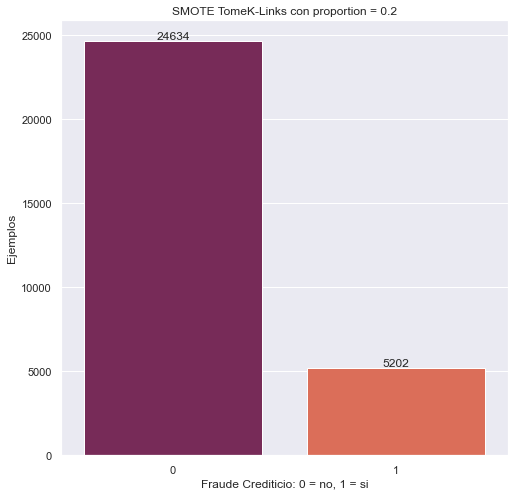

In [ ]:
dfSmoteTKLinks = pd.DataFrame(X_tklinks)
dfSmoteTKLinks = dfSmoteTKLinks.assign(col_class = y_tklinks)
dfSmoteTKLinks
ax =  sns.countplot(x='col_class', data=dfSmoteTKLinks, palette='rocket')

abs_values = dfSmoteTKLinks['col_class'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = no, 1 = si')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('SMOTE TomeK-Links con proportion = 0.2')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tklinks, y_tklinks, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(max_depth=3, random_state=0)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[8139    0]
 [1668   39]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8139
           1       1.00      0.02      0.04      1707

    accuracy                           0.83      9846
   macro avg       0.91      0.51      0.48      9846
weighted avg       0.86      0.83      0.76      9846

